# 04/11/2020

Les objectifs de cet exercice sont : 
* application et comparaison de plusieurs méthodes de segmentation
* évaluation des résultats à l'aide du coefficient Dice

In [1]:
from skimage.io import imread
from skimage.filters import threshold_otsu
from matplotlib.pyplot import imshow, show, title, figure, hist, plot, xlabel, ylabel, axvline, subplot, text
import numpy as np

In [2]:
# Calcul du Dice
def dice(img1, img2):
    img1 = img1 != 0
    img2 = img2 != 0
    return 2 * np.sum(img1*img2) / (np.sum(img1) + np.sum(img2))

In [3]:
# Affichage image segmentée et histogramme côte à côte
def myplot(img, binarized, seuil):
    figure(figsize=(12,5))
    subplot(1,2,1)
    imshow(binarized, cmap='gray')
    title('Dice = {:.3f}'.format(dice(binarized, gt)))
    subplot(1,2,2)
    hist(img.ravel(), bins=256)
    axvline(seuil, color='r')
    title("Seuil = {}".format(seuil))
    show()

L'image à segmenter (dans un premier temps) est :

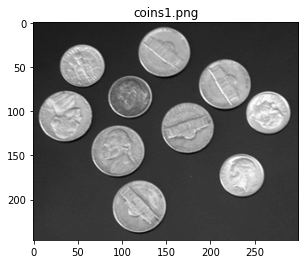

In [4]:
img = imread('coins1.png')
imshow(img, cmap='gray')
title("coins1.png")
show()

Dans le cas d'une analyse de performance, on peut comparer les résultats obtenus avec la vérité terrain. Dans notre cas, il s'agit de la segmentation optimale, représentée ci-dessous.

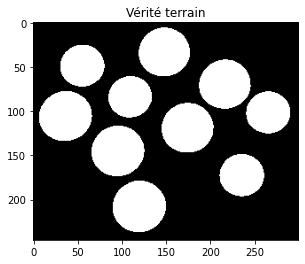

In [5]:
gt = imread('coins-groundtruth.png')
imshow(gt, cmap='gray')
title('Vérité terrain')
show()

## Seuil manuel

L'histogramme de l'image à segmenter fait apparaître clairement deux modes. Il est donc aisé de définir un seuil pour cette image en le plaçant entre ces deux modes.

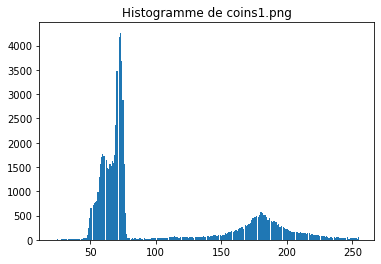

In [6]:
hist(img.ravel(), bins=256)
title("Histogramme de coins1.png")
show()

Par exemple, pour un seuil égal à 90 :

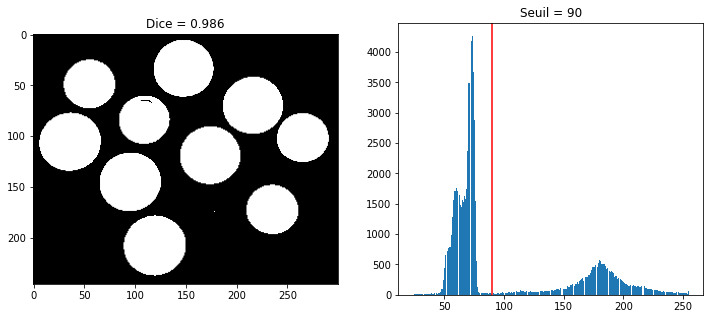

In [7]:
seuil = 90
binarized = img>seuil
myplot(img, binarized, seuil)

Avec le seuil choisi, on obtient un coefficient Dice égal à 0,986, ce qui est bien, mais pas top.

## Seuillage de Otsu

Le seuillage manuel a l'inconvénient d'être, justement, manuel. Au contraire, la méthode de Otsu permet de calculer _automatiquement_ une valeur de seuil. Cependant, dans le cas de l'image considérée, la segmentation n'est pas aussi bonne qu'avec un seuil manuel.

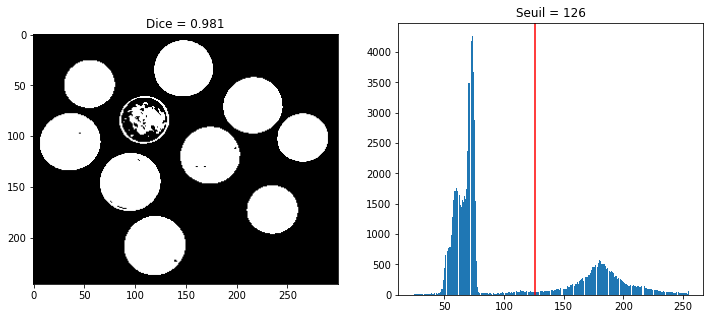

In [8]:
seuil = threshold_otsu(img, nbins=256)
binarized = (img>seuil)
myplot(img, binarized, seuil)

La méthode de Otsu trouve un seuil plus élevé que précédemment. En conséquence, il y a moins de pixels blancs dans la segmentation. La pièce légèrement plus foncée que les autres est donc moins bien segmentée.

## Méthode optimisant le coefficient Dice (connaissant la vérité terrain)

La méthode la plus simple pour trouver le meilleur seuil au sens du coefficient Dice consiste à tester toutes les valeurs de seuil (de 0 à 255) en calculant le coefficient Dice correspondant à chacun de ces seuils. Bien entendu, cette méthode n'est pas utilisable dans un cas réel puisqu'elle nécessite de connaître la vérité terrain ! Elle a cependant l'avantage de vérifier que le seuil obtenu avec la méthode de Otsu est satisfaisant car proche de la solution optimale.

La courbe ci-dessous représente l'évolution du coefficient Dice en fonction de la valeur du seuil. Le meilleur seuil correspond à la droite rouge.

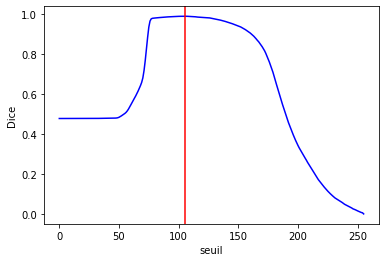

In [9]:
# Application des seuils
seuils = range(0,256)
dices = np.zeros(256)
for seuil in seuils:
    h = img>seuil
    dices[seuil] = dice(h, gt)

# Meilleur seuil
seuil = np.argmax(dices)

# Affichage
plot(seuils, dices,'b-')
axvline(seuil, color='r')
xlabel('seuil');
ylabel('Dice');
show()

Le seuil qui maximise le Dice est égal à 105, ce qui donne le résultat ci-dessous.

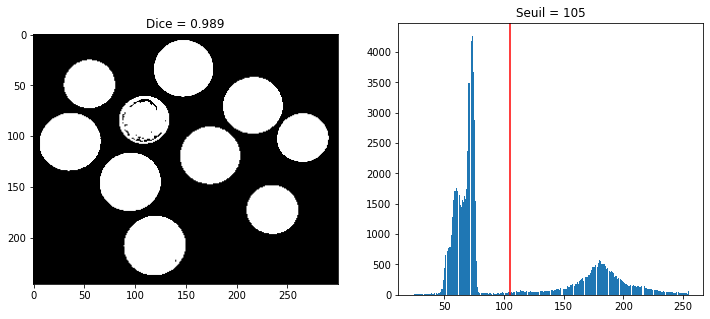

In [10]:
# Affichage
binarized = (img>seuil)
myplot(img, binarized, seuil)

Le seuil obtenu avec la méthode de Otsu n'est donc pas le meilleur, mais donne une segmentation déjà proche de la segmentation optimale.

## Seuil adaptatif pour une image avec un éclairage non uniforme

La seconde image à segmenter fait apparaître un éclairage qui varie en fonction des pixels.

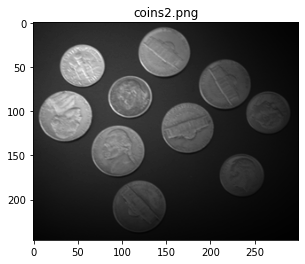

In [11]:
img = imread('coins2.png')
imshow(img, cmap='gray')
title('coins2.png')
show()

L'histogramme de cette nouvelle image est clairement plus difficile à seuiller, puisqu'on ne distingue pas deux modes qui pourraient être séparés.

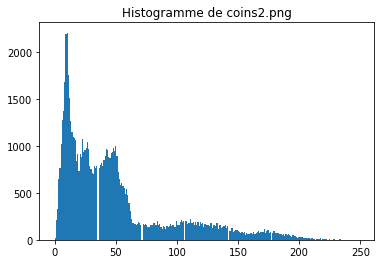

In [12]:
hist(img.ravel(), bins=256)
title("Histogramme de coins2.png")
show()

Dans ce cas, la méthode de Otsu ne donne pas un résultat acceptable, cela est confirmé par le coefficient Dice obtenu.

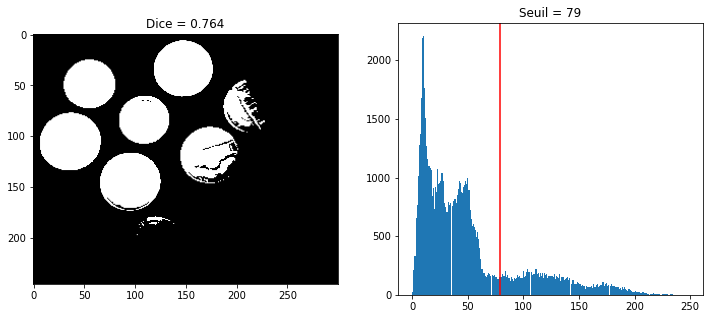

In [13]:
seuil = threshold_otsu(img, nbins=256)
binarized = (img>seuil)
myplot(img, binarized, seuil)

Ce mauvais résultat s'explique par le fait que certaines pièces, très sombres, ont une luminosité inférieure au seuil. Si le seuil était plus faible, on pourrait espérer retrouver ces pièces, au risque de considérer alors une partie du fond comme faisant partie des objets...

Pour résoudre ce problème, on effectue un seuillage adaptatif : c'est-à-dire que le seuil s'adaptera à la luminosité. Pour faire simple, on va décomposer l'image en images plus petites, sur lesquelles la luminosité peut être considérée homogène : la méthode de Otsu pourra alors être appliquée convenablement.

Le résultat du seuillage adaptatif est présenté sur l'image de gauche, et les valeurs des seuils sont représentés sur l'image de droite.

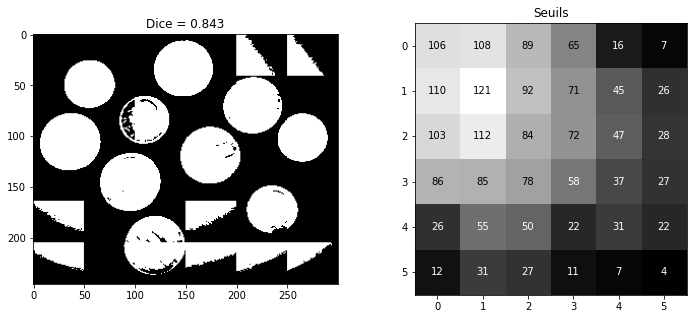

In [14]:
# Taille d'une imagette
W, H = 50, 41

# Matrice pour enregistrer les seuils successifs
seuils = np.zeros([6, 6])

# Seuillage sur chaque imagette
for r in range(6):
    for c in range(6):
        
        # Découpage de l'imagette
        m1, m2, n1, n2 = r*H, (r+1)*H, c*W, (c+1)*W
        imagette = img[m1:m2, n1:n2]
        
        # Calcul du seuil
        seuil = threshold_otsu(imagette, nbins=256)
        
        # Enregistrement du seuil
        seuils[r,c] = seuil
        
        # Segmentation
        bin_imagette = imagette>seuil
        
        # Affectation du résultat à la portion de l'image considérée
        binarized[m1:m2, n1:n2] = bin_imagette

figure(figsize=(12,5))

# Affichage de l'image segmentée
subplot(1,2,1)
imshow(binarized, cmap='gray')
title('Dice = {:.3f}'.format(dice(binarized, gt)))

# Affichage des valeurs des seuils
subplot(1,2,2)
imshow(seuils, cmap='gray')
for r in range(6):
    for c in range(6):
        text(c, r, '{:.0f}'.format(seuils[r,c]),
            horizontalalignment='center', verticalalignment='center',
            color='k' if seuils[r,c]>60 else 'w')
title('Seuils')
show()

On s'aperçoit que le seuil évolue bien spatialement, et qu'il est plus haut là où l'image est plus claire.
Mais qu'est-ce que c'est ces drôles de trucs qui apparaissent dans l'image ?

Notons également que le coefficient Dice n'est pas très bon.
Cela est dû aux faux positifs qui apparaissent dans plusieurs imagettes ;
plus précisément, les imagettes en question sont des imagettes ne contenant pas d'objet.
Une façon de résoudre ce problème est d'effectuer la segmentation
uniquement si la répartition des intensités des pixels est suffisament
importante : on peut donc utiliser l'écart-type, l'écart entre les
valeurs extrêmes, etc.
Le résultat obtenu en utilisant l'écart sur les valeurs extrêmes est
donné dans la figure ci-dessous : il est très satisfaisant cette fois-ci.

Les crois rouges sur l'image des seuils indique que la segmentation n'a pas été faite.

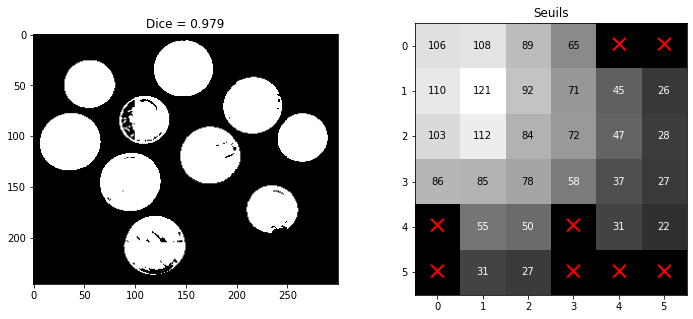

In [15]:
# Taille d'une imagette
W, H = 50, 41
seuils = np.zeros([6, 6])

for r in range(6):
    for c in range(6):
        
        # Découpage de l'imagette
        m1, m2, n1, n2 = r*H, (r+1)*H, c*W, (c+1)*W
        imagette = img[m1:m2, n1:n2]
        
        # Calcul du seuil
        seuil = threshold_otsu(imagette, nbins=256)
        
        # Affectation du résultat à la portion de l'image considérée
        # seulement s'il y a suffisament de dynamique
        if imagette.max() - imagette.min() > 25:
            seuils[r,c] = seuil
            binarized[m1:m2, n1:n2] = imagette>seuil                
        else:
            seuils[r,c] = -1  # Pas de seuil
            binarized[m1:m2, n1:n2] = np.zeros((H, W))

# Affichage image segmentée et valeurs des seuils côte à côte
figure(figsize=(12,5))
subplot(1,2,1)
imshow(binarized, cmap='gray')
title('Dice = {:.3f}'.format(dice(binarized, gt)))
subplot(1,2,2)
imshow(seuils, cmap='gray')
for r in range(6):
    for c in range(6):
        if seuils[r,c]>=0:
            text(c, r, '{:.0f}'.format(seuils[r,c]),
                horizontalalignment='center', verticalalignment='center',
                color='k' if seuils[r,c]>60 else 'w')
        else:
            text(c, r, '×',
                horizontalalignment='center', verticalalignment='center',
                color='r', fontsize=25)
title('Seuils')
show()

À ce stade, pour améliorer encore le coefficient Dice, il pourrait être utile d'appliquer des opérateurs de morphologie mathématique (tel qu'une fermeture) ou de remplir les trous (c'est-à-dire mettre en blanc les pixels noirs entourés de pixels blancs).